## Imitative Learning: IL in discrete action space

模仿学习：离散动作空间

模拟数据集中的动作,就是传统的深度学习而已

In [1]:
import torch

# 封装数据集
class Dataset(torch.utils.data.Dataset):
  
  def __init__(self):
    import numpy as np
    data = np.loadtxt('discrete_act.txt')
    self.state = torch.FloatTensor(data[:, :4])
    self.action = torch.LongTensor(data[:, -1])
    
  def __len__(self):
    return len(self.state)
  
  def __getitem__(self, i):
    return self.state[i], self.action[i]
  
dataset = Dataset()
len(dataset), dataset[0]

(20000, (tensor([-0.0028,  0.0180, -0.0188, -0.0368]), tensor(0)))

In [2]:
# 数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=8, shuffle=True, drop_last=True)
len(loader), next(iter(loader))

(2500,
 [tensor([[ 0.0623, -0.1899, -0.0070,  0.3306],
          [ 0.0777, -0.0241, -0.0074,  0.1011],
          [ 0.0626,  0.2268,  0.0048, -0.2616],
          [-0.0168,  0.0035,  0.0312,  0.1129],
          [ 0.0899, -0.0381,  0.0091,  0.0839],
          [ 0.0327, -0.0116, -0.0010,  0.1070],
          [ 0.0989, -0.3522,  0.0062,  0.5993],
          [ 0.1507, -0.0397, -0.0036,  0.1151]]),
  tensor([1, 0, 0, 1, 0, 1, 1, 1])])

In [3]:
# 定义模型
model = torch.nn.Sequential(
  torch.nn.Linear(4, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 2)
)

model(torch.randn(2, 4)).shape

torch.Size([2, 2])

In [4]:
# 训练
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  loss_fn = torch.nn.CrossEntropyLoss()
  
  for epoch in range(10):
    for i, (state, action) in enumerate(loader):
      out = model(state)
      loss = loss_fn(out, action)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
    if epoch % 1 == 0:
      out = out.argmax(dim=1)
      acc = (out == action).sum().item() / len(action)
      print(epoch, loss.item(), acc)
      
train()

0 0.2121366560459137 1.0
1 0.2145334631204605 1.0
2 0.09080201387405396 1.0
3 0.11564602702856064 1.0
4 0.4120810627937317 0.75
5 0.9859985709190369 0.75
6 0.11100051552057266 1.0
7 0.17572951316833496 0.875
8 0.19733551144599915 0.875
9 0.3027347922325134 0.875


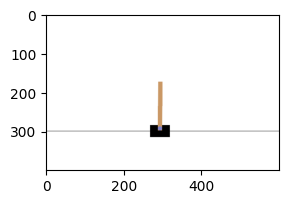

In [5]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True
      
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [8]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
    if random.random() < 0.1:
      action = env.action_space.sample()

    state, reward, over = env.step(action)
    reward_sum += reward

    if show:
      display.clear_output(wait=True)
      env.show()

  return reward_sum

# 测试
sum([play() for _ in range(20)]) / 20

200.0

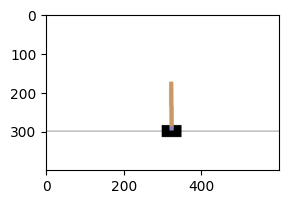

200.0

In [9]:
play(True)